[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/SURIAPRAKASH1/nano_deepseek/main/nano_deepseek_v3.ipynb)

In [ ]:
!pip install tiktoken
import tiktoken

In [ ]:
# deeplearning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# hugging face
from transformers import AutoTokenizer

# standard
import time
import math
from typing import Optional, Literal
from dataclasses import dataclass, field
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("current device -->", device)

current device --> cuda


# *MTP Experiment*

In [ ]:
# just expriement hyperparameters
batch_size = 32
block_size = 16
n_embd = 128
vocab_size = 50000

# tokens and targets ids
input_ids = torch.randint(0, vocab_size, (batch_size, block_size))  # (B, T)
target_ids = torch.randint(0, vocab_size, (batch_size , block_size))

In [ ]:
# Hmm think like it's Main model

# let say we have embeddings table
embed = nn.Embedding(vocab_size, n_embd)

# so when we have multitoken prediction module we have make some token surgery. we have to shrink in depth size
depth = 1
main_tokens = input_ids[:, :-depth]  # (B, T-depth)
main_targets = target_ids[:, :-depth]

# so let's imagine we got output from transformer. still it not preject in output head
h = embed(main_tokens)       # (batch_size, seq_len, n_embedding_dim)
h.shape

torch.Size([32, 15, 128])

In [ ]:
# Now on MTP module
mt_seq_len = main_tokens.size(-1)

for i in range(depth):
  # move token/targets right side for each MTP module
  mtp_tokens = input_ids[:, i + 1: mt_seq_len + i + 1]
  mtp_targets = target_ids[:, i + 1: mt_seq_len + i + 1]
  # mtp embeddings shared with main model
  mtp_h = embed(mtp_tokens)  # (B, T, C)

# after we have to apply RMSNorm to main model act representation and MTP module's embeddings
n1 = nn.RMSNorm(n_embd)
n2 = nn.RMSNorm(n_embd)

# apply norm add cancatination
h1 = torch.cat([n1(h), n2(mtp_h)], dim = -1)
h1.shape

torch.Size([32, 15, 256])

In [ ]:
# then do linear projection to cancatenated h1 on MTP module
proj = nn.Linear(2*n_embd, n_embd)
mtp_proj = proj(h1)

# then mtp_proj go through one transfomer block and logits projection shared with main module
# then ofcourse we have to calculate error for main and mtp module.
# for mtp module we take average over all module and multiplied with lambda = 0.3

# *V3*

In [ ]:
# open text file and read
eminem_text = open('All_eminem_songs.txt').read()
text = eminem_text

In [ ]:
# build tokenizer
tokenizer =  AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-V3')
tokens = tokenizer.encode(text)                     # we don't wanna use any special tokens
vocab_size = tokenizer.vocab_size

print("vocab size", vocab_size)
print(f"total number of charactors in our text is {len(text)} get tokenized into {len(tokens)} tokens")

Token indices sequence length is longer than the specified maximum sequence length for this model (251991 > 131072). Running this sequence through the model will result in indexing errors


vocab size 128000
total number of charactors in our text is 925005 get tokenized into 251991 tokens


In [ ]:
# Rewriting deepseek-v3 tokenizer by gpt2 tokenizer only if we wanna. we know why 50257 < 128000

# build tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(text)                     # we don't wanna use any special tokens
vocab_size = tokenizer.n_vocab

print("vocab size", vocab_size)
print(f"total number of charactors in our text is {len(text)} get tokenized into {len(tokens)} tokens")

vocab size 50257
total number of charactors in our text is 925005 get tokenized into 259541 tokens


In [ ]:
torch.cuda.manual_seed(1337) if torch.cuda.is_available() else torch.manual_seed(1337)

# train and dev dataset splits
n = int(len(tokens) * 0.9)
train_data = tokens[:n]     # 90% train dataset
dev_data =  tokens[n:]      # 10% dev dataset


def get_batch(split, device):

  data = train_data if split == 'train' else dev_data
  xi = torch.randint(len(data) - DeepSeekConfig.block_size, (DeepSeekConfig.batch_size, ))
  x = torch.tensor([data[i: i + DeepSeekConfig.block_size] for i in xi])
  y = torch.tensor([data[i + 1: i + DeepSeekConfig.block_size + 1] for i in xi])

  # pin memory so tensor is non_pageble
  if device != 'cpu':
    x = x.pin_memory()
    y = y.pin_memory()
    x = x.to(device, non_blocking = True)
    y = y.to(device, non_blocking = True)
  else:
    x = x.to(device)
    y = y.to(device)

  return x, y


print(f"train dataset {len(train_data)}\ndev dataset {len(dev_data)}")

train dataset 233586
dev dataset 25955


In [ ]:
weight_decay = 1e-2
lr = 2.2 * 10 **-4              # initial learning rate
min_lr = 2.2 * 10 ** -5
num_steps = 5000       # total number of steps used to train model
eval_interval = 500    # for calculation loss once in while
eval_iters = 200       # how many batches we should take to compute model loss

warmup_iters = 200     # we wanna use small lr during initial


def get_lr(it):

  # so we gradually increasing learning rate
  if it < warmup_iters:
    return  lr * (it + 1) / (warmup_iters + 1)

  # starting to decaying the learning rate using cosine
  else:
    decay_ratio = (it - warmup_iters)/ (num_steps - warmup_iters)
    assert 0 <= decay_ratio <=1
    coeff = 0.5 * ( 1.0 + math.cos( math.pi * decay_ratio))
    return  min_lr + coeff * (lr - min_lr)    # we make sure learning rate shouldn't 0 (but we wanna decrease)

In [ ]:
eval_iters = 200
eval_interval = 500
num_steps = 5000


@torch.no_grad()
def estimate_loss(model):
  model.eval()

  out = {}
  for split in ['train', 'dev']:
    losses = torch.zeros(2, eval_iters)
    for i in range(eval_iters):
      x, y = get_batch(split, device)
      main_loss, mtp_loss = model(x, y)
      losses[0][i] = main_loss.item()
      losses[1][i] = mtp_loss.item()

    # take means over batches
    averge_loss = losses.mean(dim = -1)
    out[split] = averge_loss

  model.train()
  return out

In [ ]:
X, Y = get_batch('train', device)

# how model going to see and predict next token
for i in range(10):
  x = X[7][:i+1].tolist()
  y = Y[7][i].tolist()
  print(x,"-->", y,"\n",tokenizer.decode(x), "-->", tokenizer.decode([y]))

[11] --> 477 
 , -->  all
[11, 477] --> 625 
 , all -->  over
[11, 477, 625] --> 262 
 , all over -->  the
[11, 477, 625, 262] --> 13342 
 , all over the -->  globe
[11, 477, 625, 262, 13342] --> 198 
 , all over the globe --> 

[11, 477, 625, 262, 13342, 198] --> 30556 
 , all over the globe
 --> Same
[11, 477, 625, 262, 13342, 198, 30556] --> 3496 
 , all over the globe
Same -->  song
[11, 477, 625, 262, 13342, 198, 30556, 3496] --> 290 
 , all over the globe
Same song -->  and
[11, 477, 625, 262, 13342, 198, 30556, 3496, 290] --> 9280 
 , all over the globe
Same song and -->  dance
[11, 477, 625, 262, 13342, 198, 30556, 3496, 290, 9280] --> 198 
 , all over the globe
Same song and dance --> 



In [ ]:
@dataclass
class DeepSeekConfig:
  n_embd: int = 144                 # vector representation for each token
  vocab_size: int = vocab_size          # number of unique tokens
  n_layers: int = 4                 # num of layers
  block_size: int = 20              # how many token's as sequence
  batch_size: int = 16              # how many sequence as a group
  inter_dim: int = 576              # intermidetate dim for mlp (usually 4 * n_embd)

  # MLA
  q_lora_dim: int = 10                        # lower rank projection dim for q
  kv_lora_dim: int = 10                       # lower rank dim for kv
  n_heads: int = 3                           # number of heads
  qk_nope_head_dim: int = 48                 # dimension for q, k wihout positional embeddings. usually n_embd // n_heads
  qk_rope_head_dim: int = 24                 # dimension for q, k with positional embeddings
  v_head_dim: int = 48                       # head dimension for v , usually n_embd // n_heads
  n_dense_layers: int = 1                    # How many Dense layer want our transformer to have

  # DeepSeekMOE
  m: int = 4                                               # fine-grained expert segmentation
  num_experts: int = 16 * m                                # How many experts in MOE?
  n_shared_experts: int = 2                                # experts that are activated always. isolated shared experts
  n_routing_experts: int = num_experts - n_shared_experts  # num of experts that are activated sparsely
  n_activated_experts: int = (2 * m) - n_shared_experts    # How many routing experts will be activated ?
  experts_dim: int = (4 * n_embd ) // m                    # what's dim of expert?
  score_func: Literal['sigmoid', 'softmax'] = 'sigmoid'    # score function for routing gate
  route_scale: float = 1.0

  # MTP
  mtp_depth: int = 1                          # how many multitoken prediction module do we want?
  mtp_lambda: float = 3e-1

  # rope
  omega: int = 10000.0

  # others
  flash_attn: bool = False
  bias: bool = False
  dropout: float = 0.0

In [ ]:
def complementary_seqwise_auxi_loss(affinity_scores: torch.Tensor, topk: int, alpha: float = 0.01)-> torch.Tensor:
  """
  Computes Complementary Sequence-Wise Auxiliary Loss

  Args:
    affinity_scores (torch.Tensor): Raw scores from Gate Layer with shape (batch, seq_len, n_routing_experts)
    topk (int): Number of Routing Activated Experts
    alpha (int) : Balance factor. As a default 1e-2

  Returns:
    loss (torch.Tensor): Scalar loss

  """
  B, T, Nr = affinity_scores.shape

  _, top_indices = torch.topk(affinity_scores, topk, dim = -1)                # (B, T, topk)

  mask = torch.zeros_like(affinity_scores).scatter(-1, top_indices, 1.0)   # (B, T, Nr)

  # frequency of How often each expert in topk
  fi = (Nr/(topk * T)) * mask.sum(1)                            # (B, Nr)

  # routing probabilites. normalized accross experts
  norm_scores = torch.softmax(affinity_scores, dim = -1)

  # mean of seq level
  pi = norm_scores.mean(dim = 1)             # (B, Nr)

  # calculating loss
  loss = alpha * (fi * pi).sum(dim = 1).mean()
  return loss


def precompute_freq_cis(args: DeepSeekConfig)-> torch.Tensor:
  """
  Precomputing frequency-based complex exponential for positional embedding.
  when viewing this complex values as real numbers we can get sin and cos

  Args:
    args (DeepSeekConfig): configuration arguments for positional embedding

  Returns:
    torch.Tensor: Precomputed complex exponential values for PE. dtype-> complex64

  """
  dim =  args.qk_rope_head_dim
  omega = args.omega
  seq_len = args.block_size

  freqs = 1.0 / (omega ** (torch.arange(0, dim, 2).float()[: dim // 2] / dim))
  t = torch.arange(seq_len)
  freqs = torch.outer(t, freqs)
  return torch.polar(torch.ones_like(freqs), freqs)        # shape (seq_len, dim // 2) -> complex64

def apply_rope(x: torch.Tensor, freqs: torch.Tensor) -> torch.Tensor:
  """

  For given input tensor applys rotary positional embeddings. rope inserts positional information about each token to itself

  Args:
    x (torch.Tensor): Input tensor that rope apply to. Shape of (B , seq_len, : , rope_dim) . (:) => n_heads when q, 1 when k
    freqs (torch.Tensor):  Precomputed complex exponential values. Shape of (seq_len, half) . half => rope_dim // 2

  Returns:
    torch.Tensor: Output tensor that rope applied. Shape of (B, seq_len, : , rope_dim)

  """
  dtype = x.dtype

  # when we view tensor as complex with shape (B, seq_len, : , half , 2)
  # last dim get trun to complex numbers real+imagine parts so shape is (B, seq_len, : , half)

  x =  torch.view_as_complex(x.float().view(*x.shape[:-1], -1, 2))    # (B, seq_len, : , half)
  freqs = freqs.view(1, x.size(1), 1, x.size(-1))                     # (1, seq_len, 1, half)
  y = torch.view_as_real(x * freqs).flatten(3)               # (B, seq_len, :, half) * (1, seq_len, 1, half) -> (B, seq_len, :, rope_dim)
  return y.to(dtype)

def linear(x: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor] = None):
  """
    Applies Linear Transformation to incomming input y = xA^T + b

  Args:
    x (torch.Tensor): The input tensor
    weight (torch.Tensor): now it just normal weight that transforms x .
                           but future if we use pretrained weights then we have to take care dequantization weights
    bias (torch.Tensor): Default is None

  Returns:
    torch.Tensor: transformed input after linear projection
  """

  if weight.element_size() > 1:  # if dtype byte size not 1 then it's normal
    return F.linear(x, weight, bias)
  # other cases not implemented right now

class Linear(nn.Module):
  """
  Custom Linear Layer

  Args:
    in_features (int): Number of inpurt features
    out_features (int): Number of output features
    bias (bool) : Wheather to add bias term or not. Default to False
    dtype (optional): data type for linear layer . Default to float32 if we use pretrained weights then we have change to match

  """
  dtype = torch.get_default_dtype()

  def __init__(self, in_features: int, out_features: int, dtype = None , bias: bool = False ):
    super().__init__()

    self.weight = nn.Parameter(torch.empty(out_features, in_features, dtype = dtype or Linear.dtype))

    # if we use pretrained weights
    if self.weight.element_size() == 1:
      pass
    else:
      nn.init.normal_(self.weight, mean = 0.0, std = 0.2)
      self.register_parameter("scale", None)

    if bias:
      self.bias = nn.Parameter(torch.empty(out_features))
    else:
      self.register_parameter('bias', None)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return linear(x, self.weight, self.bias)


class DeepSeekRMSNorm(nn.Module):
  """
    Root Mean Square Normalization. y = x/(sqrt(mean(x^2)))

    Args:
      dim (int): Input tensor dim that will be normalized
      eps (float): epsilon value for numerical stability to avoid diving x by 0 . default 1e-6

  """

  def __init__(self, dim: int, eps: float = 1e-6):
    super().__init__()

    self.dim = dim
    self.eps = eps
    # learnable weight
    self.weight = nn.Parameter(torch.ones(dim))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return F.rms_norm(x, (self.dim,), self.weight, self.eps)

class DeepSeekMLA(nn.Module):
  """
  MultiHead Latent Attention (MLA) Layer.

  Attributes:

    dim (int): Dimentionality of Input tensor. Usually same as Embedding dim
    n_heads (int): Number of Heads in MLA
    qk_rope_head_dim (int): Rotary Positional Embedding dim for query, key
    qk_nope_head_dim (int): Head dimention for query, key
    kv_lora_dim (int): Low rank projection dim for key, value
    v_head_dim (int): Head dimention for value
    softscale (int): Scale for query, key scores

  """

  def __init__(self, args: DeepSeekConfig):
    super().__init__()

    self.dim = args.n_embd
    self.n_heads = args.n_heads
    self.qk_rope_head_dim = args.qk_rope_head_dim
    self.qk_nope_head_dim = args.qk_nope_head_dim
    self.q_lora_dim = args.q_lora_dim
    self.kv_lora_dim  = args.kv_lora_dim
    self.qk_head_dim = args.qk_nope_head_dim + args.qk_rope_head_dim
    self.v_head_dim = args.v_head_dim
    self.softscale = self.qk_head_dim * -0.5
    self.flash_attn = args.flash_attn

    # don't down project q if we wanna
    if self.q_lora_dim == 0:
      self.wq = nn.Linear(self.dim, self.n_heads * self.qk_head_dim, args.bias)

    # down and up projection matrix for q and q_rope
    else:
      self.wq_a = Linear(self.dim, self.q_lora_dim)
      self.q_norm = DeepSeekRMSNorm(self.q_lora_dim)
      self.wq_b = nn.Linear(self.q_lora_dim, self.n_heads * self.qk_head_dim, args.bias)

    # down and up projection matrix for kv and k_rope
    self.wkv_a = Linear(self.dim, self.kv_lora_dim + self.qk_rope_head_dim)
    self.kv_norm = DeepSeekRMSNorm(self.kv_lora_dim)
    self.wkv_b = nn.Linear(self.kv_lora_dim, self.n_heads * (self.qk_nope_head_dim + self.v_head_dim), args.bias)

    # final projection
    self.o = nn.Linear(self.n_heads * self.v_head_dim, self.dim, args.bias)

    # regularization
    self.dropout: float = args.dropout
    self.attn_dropout = nn.Dropout(args.dropout)
    self.resid_dropout = nn.Dropout(args.dropout)


  def forward(self, x: torch.Tensor, freqs: torch.Tensor, mask: Optional[torch.Tensor]= None) -> torch.Tensor:
    B, T, C = x.shape                               # (batch_size, seq_len, embddding_dim)
    assert self.dim == C

    # down and up project q
    if self.q_lora_dim == 0:
      q = self.wq(x)
    else:
      q = self.wq_b(self.q_norm(self.wq_a(x)))                     # (B, T, n_heads* hd). hd -> (qk_nope_head_dim + qk_rope_head_dim)

    # split the q for applying rope on q's positional embedding projection
    q = q.view(B, T, self.n_heads, self.qk_head_dim)                                         # (B, T, nh, hd)
    q_nope, q_pe = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim = -1)   # (B, T, nh, qk_nope_hd), (B, T, nh, qk_rope_hd)
    q_pe = apply_rope(q_pe, freqs)

    # down project kv
    kv = self.wkv_a(x)                                                                 # (B, T, nh, kv_ld + qk_rope_hd)

    # split the kv for rope. unlike q rope, same k rope will concate with k accross heads, that's why we don't have nh dim here
    kv, k_pe = torch.split(kv, [self.kv_lora_dim, self.qk_rope_head_dim], dim = -1)    # (B, T, kv_ld), (B, T, qk_rope_hd)
    k_pe = apply_rope(k_pe.unsqueeze(2), freqs)

    # up project kv
    kv = self.wkv_b(self.kv_norm(kv))
    kv = kv.view(B, T, self.n_heads, self.qk_nope_head_dim + self.v_head_dim)
    k_nope, v = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim = -1) # (B, T, nh, qk_nope_hd), (B, T, nh, v_hd)

    # concate to get finall q, k
    q = torch.cat([q_nope, q_pe], dim = -1)                                   # (B, T, nh, hd)
    k = torch.cat([k_nope, k_pe.expand(-1, -1, self.n_heads, -1)], dim = -1)  # (B, T, nh, hd)

    # Attention. Now let the tokens communicate each others

    if self.flash_attn:
      # flash attention requires head dim next to batch dim
      attn = F.scaled_dot_product_attention(q.transpose(1, 2),
                                         k.transpose(1, 2),
                                         v.transpose(1, 2),
                                         is_causal = True,
                                         dropout = self.dropout)
      y = attn.transpose(1, 2)    # (B, hd, T, n_hd) -> (B, T, hd, v_hd)

    else:
      # do it manually
      attn_scores = torch.einsum("bshd, bthd->bsht", q, k) * self.softscale     # (B, T, hd, T)
      if mask is not None:
        attn_scores += mask.unsqueeze(1)                                        # (B, T, hd, T) + (T, 1, T)
      attn_weight = torch.softmax(attn_scores, dim = -1, dtype = torch.float32).type_as(x)
      attn_weight = self.attn_dropout(attn_weight)
      y = torch.einsum("bsht, bthd->bshd", attn_weight, v)                       # (B, T, hd, v_hd)

    # cancate all heads and do final projection
    out = self.resid_dropout(self.o(y.flatten(2)))

    return out

class DeepSeekMLP(nn.Module):
  """
  MultiLayer Perceptron (MLP) . If we wanna use Dense layer instead of MOE

  Attributes:
    w1 (Linear) : Linear Layer for input to up projection
    w2 (Linear) : Linear Layer for up projection to down projection
    w2 (Linear) : For feature transformation

  """

  def __init__(self, dim:int, inter_dim: int, args:DeepSeekConfig):
    super().__init__()

    """
      Args:

        dim (int): Input and Output dimentionaly
        inter_dim (int): Dimension of hidden layer

    """

    self.w1 = nn.Linear(dim, inter_dim, args.bias)
    self.w2 = nn.Linear(inter_dim, dim, args.bias)
    self.w3 = nn.Linear(dim, inter_dim, args.bias)
    self.mlp_dropout = nn.Dropout(args.dropout)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
      out = self.w2(F.silu(self.w1(x)) * self.w3(x))
      return self.mlp_dropout(out)

class DeepSeekGate(nn.Module):
  """
  Gate Layer - Routes the tokens to topk Experts in MOE

  Attributes:

    dim (int): Dimenstinality of the Input
    n_shared_experts (int): Number of experts activated always
    n_routing_experts (int): Number of Routing experts (that activated sparsely)
    topk (int): Number of activated experts from routing experts
    score_func ('softmax', 'sigmoid'): Score function for Routing Gate to route Input
    route_scale (float) : scaling factor for routing weights
    g_w (nn.Linear): Linear Layer for getting Gate scores
    bias (nn.Parameters): bias for controlling load balance

  """

  def __init__(self, args: DeepSeekConfig):
    super().__init__()
    self.dim = args.n_embd
    self.n_shared_experts = args.n_shared_experts
    self.n_routing_experts = args.n_routing_experts
    self.topk = args.n_activated_experts
    self.score_func = args.score_func
    self.route_scale = args.route_scale

    self.g_w = nn.Linear(self.dim, self.n_routing_experts, args.bias)
    # bias term for load balancing experts
    self.bias = nn.Parameter(torch.ones(self.n_routing_experts))

    # stores per batch seq wise auxi loss
    self.auxi_loss = None

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    device = x.device
    B, T, _ = x.shape                 # (B, T, C) ->  (batch_size, seq_len, n_embedding_dim)
    scores = self.g_w(x)              # (B, T, E) ->  E- n_routing_experts

    if self.training:
      # seq_wise loss
      self.auxi_loss = complementary_seqwise_auxi_loss(scores, self.topk)
    else:
      self.auxi_loss = None

    if self.score_func == 'softmax':
      scores = scores.softmax(dim = -1, dtype = torch.float32)
    else:
      scores = scores.sigmoid()

    original_scores = scores
    if self.bias is not None:
      scores  = scores + self.bias

    # take topk experts
    indices = torch.topk(scores, self.topk, dim = -1)[1]  # (B, T, topk)
    weights = original_scores.gather(-1, indices)

    if self.score_func == 'sigmoid':
      weights /= weights.sum(-1, keepdim = True)     # if we use sigmoid then we have to normalize the topk experts weights
    weights *= self.route_scale

    # cancating shared experts indices to activated experts indices for Efficiently handling MOE
    shared_experts_indices = torch.arange(0, self.n_shared_experts, device = device).unsqueeze(0).unsqueeze(0).expand(B, T, -1)
    expert_indices  = torch.cat([shared_experts_indices, indices + self.n_shared_experts], dim = -1)

    return weights.type_as(x), expert_indices               # (B, T, topk), (B, T, topk + shared_experts)


class DeepSeekMOE(nn.Module):

  """
    DeepSeekMOE have two special implementation:

      1. shared expert isolation.
      2. fine-grained expert segmentation.

  Attributes:
      dim (int): Dimentionaly of Input. Usually same as Embedding dim
      moe_inter_dim (int): Dimentionaly of MOE hidden state
      topk (int): Number of activated experts for Each input
      n_shared_experts (int): Number of Shared Experts
      n_routing_experts (int): Number of Rouitng experts
      num_experts (int): total Number of Experts in MOE
      gate (nn.Module) : Gate Machanisum of Routing Input to Experts
      w1 (nn.Parameter): Input to Hidden projection. All experts packed
      w2 (nn.Parameter): Hidden to Ouput projection. All experts packed
      w3 (nn.Parameter): Feature transformation. All experts packed
      act (nn.SiLU): Activation function for MOE

  """

  def __init__(self, args:DeepSeekConfig):
    super().__init__()

    self.dim = args.n_embd
    self.moe_inter_dim = args.experts_dim
    self.topk = args.n_activated_experts
    self.n_shared_experts  = args.n_shared_experts
    self.n_routing_experts = args.n_routing_experts
    self.num_experts = args.n_shared_experts + args.n_routing_experts

    # gate layer
    self.gate = DeepSeekGate(args)

    # routing and shared experts are packed togather
    self.w1 = nn.Parameter(torch.zeros(self.num_experts, self.dim, self.moe_inter_dim))
    self.w2 = nn.Parameter(torch.zeros(self.num_experts, self.moe_inter_dim, self.dim))
    self.w3 = nn.Parameter(torch.zeros(self.num_experts, self.dim, self.moe_inter_dim))

    nn.init.normal_(self.w1, mean = 0.0, std = 0.006)
    nn.init.normal_(self.w2, mean = 0.0, std = 0.006)
    nn.init.normal_(self.w3, mean = 0.0, std = 0.006)

    # act
    self.act = nn.SiLU()

    # regularization
    self.moe_dropout = nn.Dropout(args.dropout)

  def forward(self, x: torch.Tensor)-> torch.Tensor:
    device = x.device
    B, T, C = x.shape                             # (B, T, C) -> (batch_size, block_size(seq_len), embedding_dim)
    K = self.topk + self.n_shared_experts         #  all activated experts (shared and topk)

    # Gate layer only selects topk experts to be activated but shared experts always activated
    routing_weights, expert_indices = self.gate(x)   # (B, T, topk), (B, T, K)

    # flating x for efficient matrix multipilcation with experts
    x_flat = x.view(-1, C)  # (B*T, C)

    # precomputed indices for placing finall moe result into it's correct palce
    batch_indices = torch.arange(B , device = device).unsqueeze(-1).unsqueeze(-1).expand(B, T, K)   #(B, T, K)
    block_indices = torch.arange(T, device = device).unsqueeze(0).unsqueeze(-1).expand(B, T, K)     # (B, T, K)

    # flat out everything
    flat_expert_indices = expert_indices.reshape(-1)   # (B*T*K)
    flat_routing_weights = routing_weights.reshape(-1)   # (B*T*topk)

    flat_batch_indices = batch_indices.reshape(-1)   # (B*T*K)
    flat_block_indices = block_indices.reshape(-1)   # (B*T*K)

    # create copy of same token K time (K total active experts in MOE)
    x_flat = x_flat.unsqueeze(1).expand(-1, K, -1).reshape(-1, C) # (B*T*K, C)

    # plug out all experts (routing and shared) that need for moe_layer 1
    w1 = torch.einsum("bd,bde->be",
                      x_flat,                        # (B*T*K, C)
                      self.w1[flat_expert_indices]   # (B*T*K, C, E)
                      )                              # result mm way -> (B*T*K, C) @ (B*T*K, C, E)  --> (B*T*K, E) (E- expert dim)

    # feature sharing
    w3 = torch.einsum("bd,bde->be",
                      x_flat,                        # (B*T*K, C)
                      self.w3[flat_expert_indices]   # (B*T*K, C, E)
                      )                              # result -> (B*T*K, C) @ (B*T*K, C, E)  --> (B*T*K, E)

    # apply silu activation
    intermediate = self.act(w1) * w3    # (B*T*K, 1, E) * (B*T*K, 1, E)

    # moe layer 2
    experts_outputs = torch.einsum("be,bed->bd",
                                   intermediate,                   # (B*T*K, E)
                                   self.w2[flat_expert_indices]    # (B*T*K, E, C)
                                   )                               # result -> (B*T*K, E) @ (B*T*K, E, C)  --> (B*T*K, C)

    # apply dropout
    experts_outputs = self.moe_dropout(experts_outputs)

    # weight the experts (topk only not shared onces) by it crossponding routing weights
    is_routing_expert = flat_expert_indices >= self.n_shared_experts                 # mask for only selecting topk expert's activation
    weighted_expert_outputs = experts_outputs.clone()
    weighted_expert_outputs[is_routing_expert] *= flat_routing_weights.unsqueeze(-1)  # (B*T*k, C) * (B*T*k, 1)

    final_output = torch.zeros((B*T, C) ,device= device)     # (B*T, C)

    # sparse indices for accumulating tokens's activation by experts
    # eg: tensor([0, 0, .., K, 1,1, .., K, B*T-1, B*T-1, ...K])
    sparse_indices = flat_batch_indices * T + flat_block_indices
    final_output.index_add_(0, sparse_indices, weighted_expert_outputs.to(final_output.dtype))

    return final_output.view(B, T, C)

class DeepSeekBlock(nn.Module):
  """
  Transformer Block combining Attention and feedforward layers

  Attributes:
    attn (nn.Module): Attention Layer (MLA)
    ffn (nn.Module): Feed-forward network (MOE, MLP)
    attn_norm (nn.Module): Layer normalization for attention
    ffn_norm (nn.Module): Layer normalization for Fee-Forward network

  """

  def __init__(self, layer_id: int, args: DeepSeekConfig):
    super().__init__()
    """
    Args:
      layer_id (int): Current transformer layer idx
      args (DeepSeekConfig): Configuration for model

    """

    self.attn = DeepSeekMLA(args)
    self.ffn = DeepSeekMLP(args.n_embd, args.inter_dim, args) if layer_id < args.n_dense_layers else DeepSeekMOE(args)
    self.attn_norm = DeepSeekRMSNorm(args.n_embd)
    self.ffn_norm = DeepSeekRMSNorm(args.n_embd)

  def forward(self, x: torch.tensor, freqs: torch.Tensor, mask: Optional[torch.Tensor])-> torch.Tensor:
    """
    Args:
      x (torch.Tensor): Input that will feed to transformer layers
      freqs (torch.Tensor): Precomputed complex exponential values for rope
      mask (torch.Tensor): Mask for Regressive manner
    """
    x  = x + self.attn(self.attn_norm(x), freqs, mask)
    x  = x + self.ffn(self.ffn_norm(x))
    return x


class DeepSeekMTP(nn.Module):
  """
  Multi-Token Prediction Module.
  Purpose of this MTP is to make main model able to pre-plan it's representation to predict future tokens.

  Attributes:

    dim (int): Input tensor Dimentionality
    proj (nn.Linear): Linear layer for projecting
    block (nn.Module): Single Transformer block
    rep_norm (nn.Module): Normalization layer for act representation from previous module
    emb_norm (nn.Module): Normalization layer for current module embeddings

  Returns:

    torch.Tensor : Output after feeded to transformer block. shape (batch_size, seq_len, embedding_dim)

  """

  def __init__(self, layer_id: int, args: DeepSeekConfig):
    super().__init__()

    """
    Args:

      layer_id (int): Current transformer layer index
      args (DeepSeekConfig): Dataclass of All configuration for model

    """

    self.dim = args.n_embd
    self.proj = nn.Linear(2 * self.dim, self.dim, args.bias)
    self.block = DeepSeekBlock(layer_id, args)

    # normalizers
    self.rep_norm = DeepSeekRMSNorm(self.dim)
    self.emb_norm = DeepSeekRMSNorm(self.dim)

  def forward(self,
              h_prev: torch.Tensor,
              current_Memb: torch.Tensor,
              freqs: torch.Tensor,
              mask: Optional[torch.Tensor])-> torch.Tensor:
    """
    Args:

      h_prev (torch.Tensor): Previous Module transfomers block or blocks activation representation
      current_embd (torch.Tensor): Current Module token Embeddings
      freqs (torch.Tensor): Precomputed complex Exponential values for rope
      mask (torch.Tensor): Optional Casual Mask for attention

    """
    x = torch.cat([
        self.rep_norm(h_prev),
        self.emb_norm(current_Memb)
    ], dim = -1)
    x = self.proj(x)
    out =  self.block(x, freqs, mask)
    return out


class DeepSeekTransformer(nn.Module):
  """
  Transformer model with Rotary Positional Embedding, Multiple Layers and Output projection

  Attributes:
    embed (nn.Embedding): Embedding layer for transformer
    block_size (int): Sequence length
    layers (nn.ModuleList): List of transformer blocks
    mtp (nn.ModuleList): MTP- Multitoken Prediction Modules
    norm (nn.Module): Normalization Layer
    head (nn.Linear): Final ouput projection layer
    freqs (torch.Tensor): Precomputed complex exponential values for RoPE

  """

  def __init__(self, args: DeepSeekConfig):
    super().__init__()

    self.vocab_size: int = args.vocab_size
    self.block_size: int = args.block_size
    self.n_dense_layers: int = args.n_dense_layers
    self.depth: int = args.mtp_depth
    self.mtp_lambda: float = args.mtp_lambda

    self.embed = nn.Embedding(args.vocab_size, args.n_embd)

    # main model
    self.layers = nn.ModuleList([
        DeepSeekBlock(i, args) for i in range(args.n_layers)
    ])

    # MTP module
    self.mtp = nn.ModuleList([DeepSeekMTP(i, args) for i in range(args.mtp_depth)])

    self.norm = DeepSeekRMSNorm(args.n_embd)
    self.head = nn.Linear(args.n_embd, args.vocab_size, args.bias)

    # weight tying. deepseek-v3 didn't use weight tying
    # self.embed.weight = self.head.weight

    # weight initialization
    self.apply(self._init_weight)

    self.register_buffer('freqs', precompute_freq_cis(args), persistent= False)

    # report total parameters in model
    print("total parameters %.2f" % (self._get_total_parameters()/ 1e+6),"M")
    print("active parameters %.2f" % (self._get_active_parameters(args)/1e+6),"M")

  def _init_weight(self, module):
    with torch.no_grad():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean = 0.0, std = 0.006)
        if module.bias is not None:
          nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean = 0.0, std = 0.006)

  def device(self):
    return next(self.parameters()).device

  def _get_total_parameters(self) -> int:
    """
      Returns total parameters in our model
    """
    t = 0
    for p in self.parameters():
      t += p.nelement()
    return t

  def _get_active_parameters(self, args: DeepSeekConfig) -> int:
    """
    Returns active parameters in our model
    """
    not_active_experts = args.num_experts - (args.n_activated_experts + args.n_shared_experts)
    not_active_experts_pcount = args.n_embd * args.experts_dim * not_active_experts

    t = 0
    for np, p in self.named_parameters():
      if np.endswith('ffn.w1') or np.endswith('ffn.w2') or np.endswith('ffn.w3'):
        t += p.nelement() - not_active_experts_pcount
      else:
        t += p.nelement()
    return t

  def forward(self, input_ids:torch.Tensor, target_ids: Optional[torch.Tensor] = None) -> torch.Tensor:
    """
    Transformer forward pass

    Args:
      input_ids (torch.Tensor): Input tensor of token ID's with shape (batch, seq_len)
      target_ids (Optional[torch.Tensor]): Ground truth ID's of token with shape (batch, seq_len). If provided loss will be computed

    Returns:
      torch.Tensor: Logits with shape of (batch, vocab_size)
      loss (torch.Tensor): Loss will be computed using cross_entropy . if only target is given

    """
    if not self.training and target_ids is None or self.depth == 0:
      main_tokens_ids = input_ids
      seq_len = main_tokens_ids.size(-1)

    else:
      # shrink the tokens sequence length in main model
      main_tokens_ids = input_ids[:, :-self.depth]   # (B, T - depth)
      seq_len = main_tokens_ids.size(-1)

    h = self.embed(main_tokens_ids)
    freqs = self.freqs[ :seq_len]
    mask = None

    if seq_len > 1:
      mask = torch.full((seq_len, seq_len), float('-inf'), device = input_ids.device).triu_(1)

    for layer in self.layers:
      h = layer(h, freqs, mask)

    # norm before logits
    h_main = self.norm(h)

    if target_ids is not None:

      h_prev = h_main
      mtp_loss = 0.0

      for d in range(self.depth):
        # move the input_ids, target_ids right side with d size
        indices = slice(d + 1, seq_len + d + 1)

        mtp_freqs = self.freqs[indices]

        mtp_token_ids = input_ids[:, indices]
        mtp_target_ids = target_ids[:, indices]

        # embedding shared with main model
        mtp_emb = self.embed(mtp_token_ids)

        assert h_prev.shape == mtp_emb.shape,f"previous module with shape {h_prev.shape}, current module embedding with shape {mtp_emb.shape}"

        # MTP modules
        h_current = self.mtp[d](h_prev, mtp_emb, mtp_freqs, mask)

        # output head shared with main model
        mtp_logits = self.head(h_current)
        h_prev = h_current

        # compute loss
        mtp_l = F.cross_entropy(
            mtp_logits.view(-1, self.vocab_size),
            mtp_target_ids.reshape(-1)         # don't know why view ain't good with slice
        )

        mtp_loss += mtp_l / self.depth


      main_logits = self.head(h_main)
      # main loss
      main_loss = F.cross_entropy(main_logits.view(-1, self.vocab_size), target_ids[:, :seq_len].reshape(-1))
      # mtp loss
      if mtp_loss:
        main_loss += self.mtp_lambda * mtp_loss

      # complementry seq_wize auxiliary loss
      total_auxi_loss = 0.0
      if self.training:
        for i in range(self.n_dense_layers, len(self.layers)):
          total_auxi_loss +=  self.layers[i].ffn.gate.auxi_loss

        main_loss += total_auxi_loss

    else:
      # finall logits modification
      logits = self.head(h_main[:, [-1], :])
      return logits

    return main_loss, mtp_loss

  def generate(self, idx, max_tokens, temperature = 0.8, top_k = None):
    # idx (b, t) by takes previous sequence we try to complete the sequence so

    with torch.no_grad():
      for _ in range(max_tokens):
        # we croping the block size we can take infinite pre-context to predict next token
        idx_count = idx if idx.size(1) <= self.block_size else idx[:,- self.block_size:]
        logits  = self(idx_count)

        logits = logits[:, -1, :] / temperature

        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('inf')

        probs = torch.softmax(logits, dim = -1)
        next_idx = torch.multinomial(probs, num_samples=1)

        # then add the next token to our token seq so next time model can predict token based on this token
        idx = torch.cat((idx, next_idx), dim=1)

    return idx

In [ ]:
model = DeepSeekTransformer(DeepSeekConfig).to(device)
loss, mtp_loss =  model.forward(X, Y)

print("Before traning:")
print(f"loss: {loss}")
print(" ")

print("generated token:\n" ,
      tokenizer.decode(model.generate(torch.zeros(1, 2, dtype = torch.int32, device = device), max_tokens = 20, temperature= 0.7)[0].tolist()))


total parameters 27.15 M
active parameters 16.70 M
Before traning:
loss: 17.351106643676758
 
generated token:
 !! nationalists HPVEmpty hinges Seconds Infinite harmfulPolittext "/ Bio har Recalladish exciting Incident Solitaire refrigerator grip matched


In [ ]:
# Adam with decoupled weight decay that called AdamW 😑
optimizer = optim.AdamW(model.parameters(), betas= (0.9, 0.95), weight_decay= weight_decay)
scaler = torch.amp.GradScaler(device = device)

In [ ]:
@dataclass
class Loss:
  main_loss: list = field(default_factory= list)
  mtp_loss: list = field(default_factory= list)

In [ ]:
# optimization loop
pb_lossi = []    # loss for per-batch
gb_lossi = defaultdict(Loss)    # loss for some bunch of batches

start = time.time()
for step in range(num_steps):
  # get batch of (x, y) pair
  X, Y = get_batch('train', device)

  optimizer.zero_grad()

  # forward pass and compute loss
  # when using amp autocast it runs model in f16/b16 and returns f16/b16 loss (regardless of input type)
  with torch.amp.autocast(device_type =  device, dtype = torch.bfloat16):
    loss, _, = model(X, Y)

  # back-ward pass
  # scale the loss and cumulate gradients for that scaled loss (so gradients are big)
  scaler.scale(loss).backward()

  # grad clip
  scaler.unscale_(optimizer)
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= 1.0)

  # update parameters
  # so we can't simply multiply parameters with big gradients we have scale down
  optimizer.defaults['lr'] = get_lr(step)
  scaler.step(optimizer)
  scaler.update()

  # evaluate model once in while
  if step % eval_interval == 0 or step  == num_steps - 1:
    out = estimate_loss(model)

    # for plotting loss curve
    gb_lossi['train'].main_loss.append(out['train'][0].item())
    gb_lossi['train'].mtp_loss.append(out['train'][1].item())

    gb_lossi['dev'].main_loss.append(out['dev'][0].item())
    gb_lossi['dev'].mtp_loss.append(out['dev'][1].item())


    print(f"step {step}/{num_steps}: train: main_loss {out['train'][0].item()} mtp_loss {out['train'][1].item()}, dev: main_loss {out['dev'][0].item()} mtp_loss {out['dev'][1].item()}")

  pb_lossi.append(loss.item())

end = time.time()
print("training time: %.2f" % ((end - start)/60),"M")

step 0/7000: train: main_loss 17.31415557861328 mtp_loss 21.6496524810791, dev: main_loss 17.31441307067871 mtp_loss 21.649667739868164
step 500/7000: train: main_loss 9.105355262756348 mtp_loss 11.344156265258789, dev: main_loss 9.487813949584961 mtp_loss 11.845516204833984
step 1000/7000: train: main_loss 8.519488334655762 mtp_loss 10.501112937927246, dev: main_loss 9.110121726989746 mtp_loss 11.364157676696777
step 1500/7000: train: main_loss 8.204524993896484 mtp_loss 10.088448524475098, dev: main_loss 9.037236213684082 mtp_loss 11.259238243103027
step 2000/7000: train: main_loss 7.956005096435547 mtp_loss 9.745068550109863, dev: main_loss 8.934518814086914 mtp_loss 11.175689697265625
step 2500/7000: train: main_loss 7.7726969718933105 mtp_loss 9.486388206481934, dev: main_loss 8.91312026977539 mtp_loss 11.173300743103027
step 3000/7000: train: main_loss 7.610513687133789 mtp_loss 9.230932235717773, dev: main_loss 8.90250015258789 mtp_loss 11.189648628234863
step 3500/7000: train: 

```
Try 4:
  Model Info:
    1. same as Try 3 (1-3)
    2. vocab -> gpt2_50k
    3. steps = 7k

total parameters 27.15 M
active parameters 16.70 M
training time: 18.05 M

step 0/7000: train: main_loss 17.31415557861328 mtp_loss 21.6496524810791, dev: main_loss 17.31441307067871 mtp_loss 21.649667739868164
step 6999/7000: train: main_loss 7.084712028503418 mtp_loss 8.359647750854492, dev: main_loss 9.11233139038086 mtp_loss 11.682860374450684


Try 3:
  Model Info:
    1. No weight tying
    2. No dropout = 0.0
    3. MLP (block with dense layer)

total parameters 49.54 M
active parameters 39.09 M
training time: 13.32 M

step 0/5000: train_loss tensor([18.8130, 23.5196]), dev_loss tensor([18.8133, 23.5196])
step 4999/5000: train_loss tensor([7.4357, 8.9387]), dev_loss tensor([ 9.5190, 12.1804])

Try 2:
  Model Info:
    1. weight tying
    2. sigmoid for gate
    4. No MLP module

step 4999/5000: train_loss 4.647718906402588, dev_loss 5.798486232757568, scale factor 4096.0
training time: 34.56 M

Try 1:
  Model Info:
    1. dropout = 0.2 except for feed before transfomer that used in like gpt
    2. softmax for gate  
    3. No weight tying
    4. No MLP module

total parameters 78.22 M
active parameters 53.44 M

step 4999/5000: train_loss 4.3448567390441895, dev_loss 5.843522548675537, scale factor 8192.0
traning time: 34.55 M
```

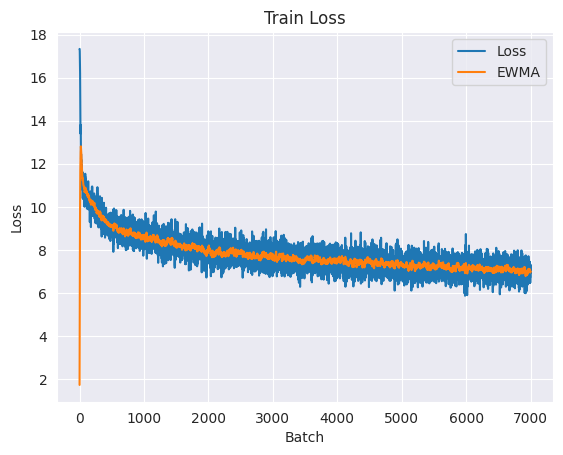

In [ ]:
# Exponential weight Moving average loss. In Adam style
per_batch_loss = []
v0 = 0.0
beta = 0.9

for i, l in enumerate(pb_lossi, 1):
  v1 = beta * v0 + (1 - beta) * l
  v0 = v1
  per_batch_loss.append(v1)

plt.plot(pb_lossi)
plt.plot(per_batch_loss)

plt.xlabel("Batch")
plt.ylabel('Loss')

plt.legend(['Loss', "EWMA"])

plt.title("Train Loss")
plt.show()

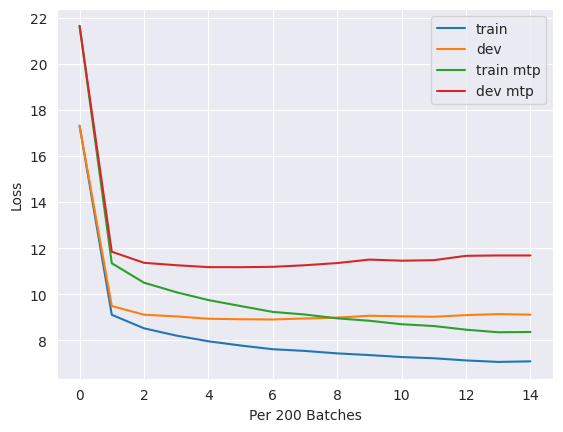

In [ ]:
# train and dev loss curve
plt.plot(gb_lossi['train'].main_loss)
plt.plot(gb_lossi['dev'].main_loss)

plt.plot(gb_lossi['train'].mtp_loss)
plt.plot(gb_lossi['dev'].mtp_loss)

plt.ylabel('Loss')
plt.xlabel(f'Per {eval_iters} Batches')

plt.legend(['train', 'dev', "train mtp", "dev mtp"])
plt.show()

In [ ]:
model.eval()
# sampling from model
query = """
yo his pawms are swetty
"""

encoded_query = torch.tensor([tokenizer.encode(query)], device = device)
result = tokenizer.decode(model.generate(encoded_query, temperature= 0.7, top_k= 100, max_tokens = 200)[0].tolist())

In [ ]:
print(result)


yo his pawms are swetty
I had to a little controversy?

I just heard you're on me
You know
If you hear the fuck is like a c'm not even
And I'm the fuck on everyone
And there's why I'm so much that I'm a damn big
I've done got the same rap, I'm a closet
I told you'd never meant to me
I'm a fucking body
I'mma play my face
You can be a thousand times
It's the party from these rappers
You were gonna take our heart to me
Here, I'm going to a shit
And I'm not an ass, I'm on
I'mma get so bad, 'cause you can't get to make you

Like I'm a shit, but I'm the fucking head
I'm just to give me from hold of the only of the mic and my music
But I'm backstabber
I'm going to the hell, I'm
